# Setup

This script isolates coastal profiles from the World Ocean Database.

In [1]:
# import packages
%run ../../global_packages.py

# get the global parameters
%run ../../global_pars.py

# import your local functions
sys.path.insert(1, '../../')
from global_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Parameters and Paths

In [2]:
outfn = 'IO_coastal_mask.nc'

# Get Data

In [3]:
ds_WOD = xr.open_dataset('../0_WOD/wod_processed.nc')
ds_WOD

<xarray.Dataset>
Dimensions:           (depth: 57, time: 319847)
Coordinates:
  * time              (time) datetime64[ns] 1948-03-10 1948-03-11 ... 2020-05-31
  * depth             (depth) int64 0 5 10 15 20 25 ... 1300 1350 1400 1450 1500
Data variables:
    temp              (time, depth) float64 ...
    sal               (time, depth) float64 ...
    doxy              (time, depth) float64 ...
    nitrate           (time, depth) float64 ...
    phosphate         (time, depth) float64 ...
    lat               (time) float32 ...
    lon               (time) float32 ...
    cast_id           (time) object ...
    temp_40_200       (time) float64 ...
    doxy_40_200       (time) float64 ...
    sal_40_200        (time) float64 ...
    nitrate_40_200    (time) float64 ...
    phosphate_40_200  (time) float64 ...
    temp_50_200       (time) float64 ...
    doxy_50_200       (time) float64 ...
    sal_50_200        (time) float64 ...
    nitrate_50_200    (time) float64 ...
    phosphate

In [4]:
ds_mask = xr.open_dataset('dist2coast_1deg_indian_ocean.nc')
ds_mask

<xarray.Dataset>
Dimensions:  (lat: 3501, lon: 7001)
Coordinates:
  * lat      (lat) float32 30.0 29.99 29.98 29.97 ... -4.97 -4.98 -4.99 -5.0
  * lon      (lon) float32 40.0 40.01 40.02 40.03 ... 109.97 109.98 109.99 110.0
Data variables:
    dist     (lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    history:                         2012-07-12T00:00:00Z Downloaded GeoTIFF ...
    nco_openmp_thread_number:        1
    id:                              dist2coast_1deg_ocean
    naming_authority:                org.pacioos
    metadata_link:                   http://pacioos.org/metadata/dist2coast_1...
    ISO_Topic_Categories:            location
    title:                           Distance to Nearest Coastline: 0.01-Degr...
    summary:                         A global data set of ocean distances fro...
    keywords:                        Earth Science > Oceans > Coastal Process...
    keywords_vocabulary:             GCMD Science Keywords
 

In [5]:
ds_L17 = xr.open_dataset('Laruelle_2017_coastal_ocean_mask.nc')
ds_L17

<xarray.Dataset>
Dimensions:                    (latitude: 720, longitude: 1440)
Coordinates:
  * latitude                   (latitude) float64 -89.88 -89.62 ... 89.62 89.88
  * longitude                  (longitude) float64 -179.9 -179.6 ... 179.6 179.9
Data variables:
    mask_coastal1              (longitude, latitude) float64 ...
    mask_coastal2              (longitude, latitude) float64 ...
    mask_global_ocean          (longitude, latitude) float64 ...
    surface_mask_coastal1      (longitude, latitude) float64 ...
    surface_mask_coastal2      (longitude, latitude) float64 ...
    surface_mask_global_ocean  (longitude, latitude) float64 ...

# Interpolate to 1/4 degree

In [6]:
# do this because to intensive to use full 0.1 degree data

mask_o = np.array(ds_mask.dist)
lon = np.array(ds_mask.lon)
lat = np.array(ds_mask.lat)
xx,yy = np.meshgrid(lon,lat)

# use my global function latlonbin
mask,bincounts,latbins,lonbins = latlonbin(mask_o.flatten(),yy.flatten(),xx.flatten(), bounds = cm_bounds)


../../global_functions.py:49: RuntimeWarning: Mean of empty slice
  invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)


## Wide Shelf (later used for eAS and eBoB) using ~300km from coast from Laruelle et al 2017

In [7]:
maskw_L17 = ds_L17.mask_coastal2

lat_slice = slice(lat_bounds[0], lat_bounds[1])
lon_slice = slice(lon_bounds[0], lon_bounds[1])

#subset gridded data
maskw_L17 = maskw_L17.sel(latitude = lat_slice, longitude = lon_slice)

In [8]:
lat_L17 = np.array(maskw_L17.latitude)
lon_L17 = np.array(maskw_L17.longitude)
maskw_L17 = np.array(maskw_L17).astype(int).T
xx_L17,yy_L17 = np.meshgrid(lon_L17,lat_L17)

# remove nicobar islands
maskw_L17 = np.where(~((yy_L17>7) & (yy_L17<13.75) & (xx_L17>92) & (xx_L17<94)),maskw_L17,False)

Text(0.5, 1.0, 'Wide Shelf Mask, 300km from Coast')

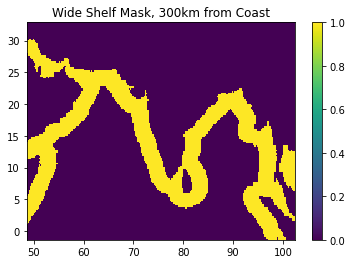

In [9]:
plt.pcolor(lon_L17,lat_L17,maskw_L17)
plt.colorbar()
plt.title('Wide Shelf Mask, 300km from Coast')

## Narrow Shelf (later used for wAS and wBoB) 150km from coast using from distance from coast dataset.

In [10]:
maskn = np.array(mask)
maskn[maskn > 150] = np.nan

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Text(0.5, 1.0, 'Narrow Shelf, 150km from Coast')

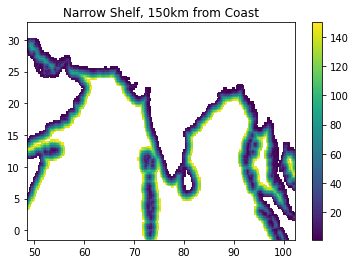

In [11]:
plt.pcolor(lonbins,latbins,maskn)
plt.colorbar()
plt.title('Narrow Shelf, 150km from Coast')

In [12]:
ds_out=xr.Dataset()

# add plain masks to dataset
ds_out['maskw'] = xr.DataArray(maskw_L17,dims = ['latw','lonw'],coords =[lat_L17,lon_L17])
ds_out['maskn'] = xr.DataArray(maskn,dims = ['latn','lonn'],coords =[latbins,lonbins])
ds_out

<xarray.Dataset>
Dimensions:  (latn: 138, latw: 138, lonn: 216, lonw: 216)
Coordinates:
  * latw     (latw) float64 -1.375 -1.125 -0.875 -0.625 ... 32.38 32.62 32.88
  * lonw     (lonw) float64 48.62 48.88 49.12 49.38 ... 101.6 101.9 102.1 102.4
  * latn     (latn) float64 -1.5 -1.25 -1.0 -0.75 -0.5 ... 32.0 32.25 32.5 32.75
  * lonn     (lonn) float64 48.5 48.75 49.0 49.25 ... 101.5 101.8 102.0 102.2
Data variables:
    maskw    (latw, lonw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    maskn    (latn, lonn) float64 nan nan nan nan nan ... nan nan nan nan nan

# Apply to WOD

In [13]:
inlat = ds_WOD.lat
inlon = ds_WOD.lon

maskw_wod = mask_coast(inlat,inlon,ds_out.maskw,ds_out.latw,ds_out.lonw)
maskn_wod = mask_coast(inlat,inlon,ds_out.maskn,ds_out.latn,ds_out.lonn)

ds_out['maskw_wod'] = xr.DataArray(maskw_wod,dims = ['loc_wod'],coords =[np.arange(len(maskw_wod))])
ds_out['maskn_wod'] = xr.DataArray(maskn_wod,dims = ['loc_wod'],coords =[np.arange(len(maskw_wod))])

Text(0.5, 1.0, 'Orignal Profile Locations')

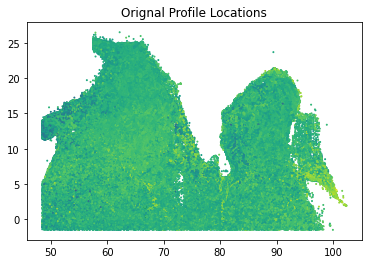

In [17]:
plt.scatter(inlon,inlat,c = ds_WOD.temp_50_200, s = 1)
plt.title('Orignal Temperature Profile Locations')

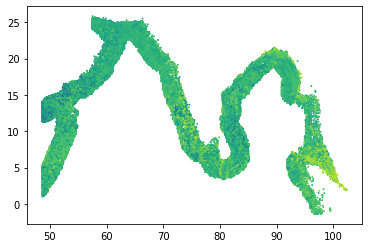

In [15]:
tmp = np.array(ds_WOD.temp_50_200)
plt.scatter(inlon[maskw_wod],inlat[maskw_wod],c = tmp[maskw_wod], s = 1)
plt.title('Wide Mask Temperature Profile Locations')

Text(0.5, 1.0, 'Narrow Mask Temperature Profile Locations')

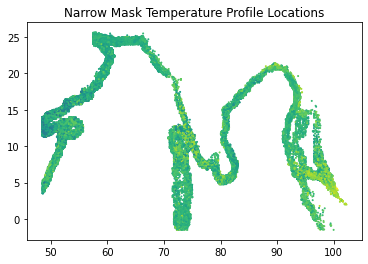

In [18]:
plt.scatter(inlon[maskn_wod],inlat[maskn_wod],c = tmp[maskn_wod], s = 1)
plt.title('Narrow Mask Temperature Profile Locations')

# SAVE

In [19]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")

In [20]:
ds_out

<xarray.Dataset>
Dimensions:    (latn: 138, latw: 138, loc_wod: 319847, lonn: 216, lonw: 216)
Coordinates:
  * latw       (latw) float64 -1.375 -1.125 -0.875 -0.625 ... 32.38 32.62 32.88
  * lonw       (lonw) float64 48.62 48.88 49.12 49.38 ... 101.9 102.1 102.4
  * latn       (latn) float64 -1.5 -1.25 -1.0 -0.75 ... 32.0 32.25 32.5 32.75
  * lonn       (lonn) float64 48.5 48.75 49.0 49.25 ... 101.5 101.8 102.0 102.2
  * loc_wod    (loc_wod) int64 0 1 2 3 4 ... 319842 319843 319844 319845 319846
Data variables:
    maskw      (latw, lonw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    maskn      (latn, lonn) float64 nan nan nan nan nan ... nan nan nan nan nan
    maskw_wod  (loc_wod) bool False False True False ... False False True False
    maskn_wod  (loc_wod) bool False False False False ... False False False